In [44]:
import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import time
import matplotlib.pyplot as plt
!pip install pandas
import pandas as pd
import pickle

You should consider upgrading via the 'pip install --upgrade pip' command.


In [45]:
train = pd.read_csv("TrainMyriad.csv")

In [46]:
train.tail()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,Class
9995,0.002683,-0.028763,-0.003444,-0.023497,1.110000e-14,-1.790000e-14,3.467799e-02,1.641587e-02,0.034320,-1.951854e-03,...,1.202405e-02,-0.007426,-1.640000e-14,9.770000e-15,-0.021945,-0.012749,5.330000e-15,0.001033,0.005676,1
9996,0.000111,0.001554,0.000000,-0.012970,5.278527e-03,3.798458e-03,-8.903730e-04,6.572352e-03,-0.003541,1.632608e-02,...,8.880000e-16,0.008390,-7.537197e-03,-6.115001e-03,0.014687,-0.008802,4.045387e-03,0.004815,-0.004499,1
9997,0.002763,-0.011523,-0.030917,0.013860,2.166624e-02,5.049230e-03,3.516704e-03,-6.660000e-16,-0.000250,4.506760e-03,...,-1.876759e-03,0.006894,-8.880000e-16,5.291005e-03,-0.006502,-0.016516,-2.408112e-02,0.032792,-0.001886,1
9998,0.000162,-0.002269,0.003087,0.001782,9.054160e-03,-3.204610e-04,-2.780000e-15,-3.526210e-03,0.007238,2.235710e-03,...,-7.865760e-04,-0.002493,-3.288180e-03,1.530750e-02,-0.004029,-0.006655,-1.011560e-02,-0.002920,0.002130,0
9999,-0.009050,0.005620,0.008244,0.001247,-1.605536e-02,-1.266001e-03,7.605634e-03,-2.795639e-03,-0.003084,1.550000e-15,...,5.219207e-03,-0.023076,2.007795e-03,-3.653937e-03,0.006388,-0.014576,-1.860909e-02,-0.009116,-0.006869,1


In [ ]:
Class = train.pop('Class')

In [6]:
np.sum(Class) / len(Class)

0.4995

The two classes of the dataset are well balanced

In [28]:
Class.iloc[0:2]

0    1
1    0
Name: Class, dtype: int64

Text(0.5, 1.0, 'Real Serie')

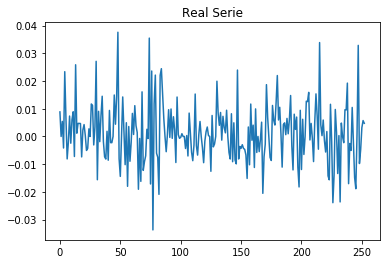

In [29]:
plt.plot(train.values[0])
plt.title('Real Serie')

Text(0.5, 1.0, 'synthetic Serie')

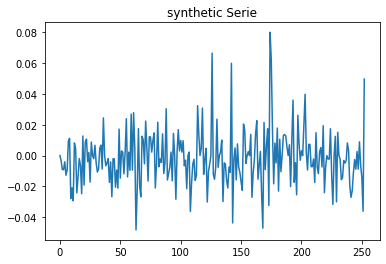

In [30]:
plt.plot(train.values[1])
plt.title('synthetic Serie')

  The data file is compound of 10 000 time series of 253 points. So there is enough data to use a deep learning architecture.
  
  The first step is to choose the model. This is a classification problem on time series. I've already had this problem in class with temperatures series. To solve the problem we had to implement a RNN. The outputs of the RNN were averaged and the dimension was reduced to the number of classes using a dense layer. Then the probabilities were given with a softmax layer and the model is fitted using the cross-entropy loss.
  
  This solution is not the best, the goal was to work with RNN to do classification and then sequence generation. Accocrding to the article "Deep learning for time series classification: a review" the best method is to use a ResNet model. This is the best deep learning model in most of the cases and it reaches almost same results as the state-of-the-art heavier algorithm HIVE-COTE, which uses an ensemble of classifiers. 

## Model

   ResNet is a convolutional neural networks improved with residual connexion to avoid vanishing gradient and batch normalization to prevent overfitting. It is one of the best deep learning model for images and it is easily adaptable to time series which are just one-dimensional images. 

In [48]:
#Defining the Convolutional residual block

class ResnetBlock(tf.keras.Model):
  def __init__(self, nb_filters):
    super(ResnetBlock, self).__init__(name='')

    self.conv_a = tf.keras.layers.Conv1D(nb_filters, 8, padding='same')
    self.bn_a = tf.keras.layers.BatchNormalization()

    self.conv_b = tf.keras.layers.Conv1D(nb_filters, 5, padding='same')
    self.bn_b = tf.keras.layers.BatchNormalization()

    self.conv_c = tf.keras.layers.Conv1D(nb_filters, 3, padding='same')
    self.bn_c = tf.keras.layers.BatchNormalization()
    
    #"identity convolution" so the input has the same dimension even if the number of channels is different initially
    self.conv_input = tf.keras.layers.Conv1D(nb_filters, 1, padding='same')
    self.bn_input = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv_a(input_tensor)
    x = self.bn_a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv_b(x)
    x = self.bn_b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv_c(x)
    x = self.bn_c(x, training=training)

    x += self.bn_input(self.conv_input(input_tensor))
    return tf.nn.relu(x)


In [49]:
def build_model(input_shape, nb_classes, nb_filters):

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    block1 = ResnetBlock(nb_filters)
    output_block_1 = block1(input_layer)

    # BLOCK 2

    block2 = ResnetBlock(2 * nb_filters)
    output_block_2 = block2(output_block_1)

    # BLOCK 3

    block3 = ResnetBlock(2 * nb_filters)
    output_block_3 = block3(output_block_2)


    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    return model


In [50]:
m = build_model([253,1], 2, 64)
m.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 253, 1)]          0         
_________________________________________________________________
resnet_block_51 (ResnetBlock (None, 253, 64)           34624     
_________________________________________________________________
resnet_block_52 (ResnetBlock (None, 253, 128)          207360    
_________________________________________________________________
resnet_block_53 (ResnetBlock (None, 253, 128)          281088    
_________________________________________________________________
global_average_pooling1d_17  (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 523,330
Trainable params: 520,770
Non-trainable params: 2,560
________________________________________________

## Fit the model

In [51]:
# input data must have an additional dimension and class must be a collection of one-hot vector rather than int
train = tf.expand_dims(train.values,2)
Class = keras.utils.to_categorical(Class.values)


In [88]:
Class[-5:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [66]:
loss_memory =[]
val_loss_memory =[]
accuracy_memory=[]
val_accuracy_memory=[]

In [65]:
train0 = tf.random.shuffle(train, seed=5)
Class0 = tf.random.shuffle(Class, seed=5)

In [72]:
### Training parameters
batch_size = 64
nb_filters = 64
nb_epochs = 20


model = build_model([253,1], 2, nb_filters)
model.load_weights('last_model5')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model5', monitor='val_loss',
                                                          save_best_only=True)
callbacks = [reduce_lr, model_checkpoint]

start_time = time.time()
hist = model.fit(train0, Class0, batch_size=batch_size, epochs=nb_epochs,
                              verbose=1, validation_split=0.3, callbacks=callbacks)
duration = time.time() - start_time
print('total duration: ', duration)

loss_memory += hist.history['loss']
val_loss_memory += hist.history['val_loss']
accuracy_memory += hist.history['accuracy']
val_accuracy_memory += hist.history['val_accuracy']
model.save_weights('last_model5', save_format='tf')



Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0659 - accuracy: 0.9773 - val_loss: 12.7300 - val_accuracy: 0.5197
Epoch 2/20
7000/7000 [==============================] - 4s 621us/sample - loss: 0.0357 - accuracy: 0.9893 - val_loss: 13.7660 - val_accuracy: 0.5177
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0110 - accuracy: 0.9974 - val_loss: 6.0190 - val_accuracy: 0.5500
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0075 - accuracy: 0.9984 - val_loss: 2.9962 - val_accuracy: 0.5767
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0080 - accuracy: 0.9979 - val_loss: 2.6349 - val_accuracy: 0.5823
Epoch 6/20
7000/7000 [==============================] - 4s 618us/sample - loss: 0.0067 - accuracy: 0.9989 - val_loss: 2.6761 - val_accuracy: 0.5773
Epoch 7/20
7000/7000 [==============================] - 4s 618us/s

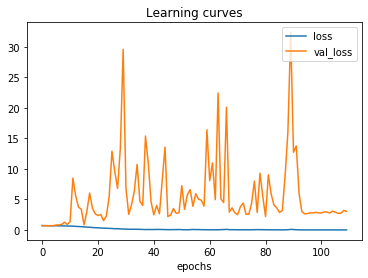

In [73]:
plt.plot(loss_memory)
plt.plot(val_loss_memory)
plt.legend(['loss','val_loss'], loc='upper right');
plt.title('Learning curves')
plt.xlabel('epochs')
plt.show()

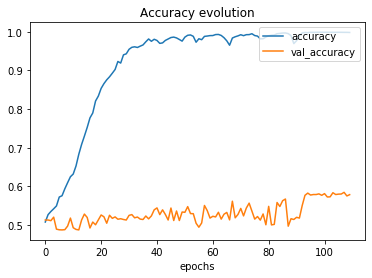

In [74]:
plt.plot(accuracy_memory)
plt.plot(val_accuracy_memory)
plt.legend(['accuracy','val_accuracy'], loc='upper right');
plt.title('Accuracy evolution')
plt.xlabel('epochs')
plt.show()

Model fitting is efficient as the loss decreases. There is no overfitting because the validation loss is globaly constant or decreasing slightly. Even if the cross-entropy loss of the validation set is high the accuracy is increasing above 0.55 so the model has a capacity of generalization for classification.

I've run different experiments to choose hyperparameters. Increasing the number of filters of each convolution layer or adding an extra ResNet block makes training longer but does not improve the validation accuracy. The model is already sufficiently complex. However deleting the last layer or reducing the number of filters does leads to worse validation results. So this model have the good number of parameters, that must be why this is exactly the model used in the article "Deep learning for time series classification: a review".

## Final Model and predictions on test

The article "Deep Neural Network Ensembles for Time Series Classification" shows that an ensemble of models with random initialization is often better than a single model for time series classification. This is due to the high variance of neural networks. As the training is fast it is worth to train several models on the whole dataset and to use this ensemble of models for the final classifier. Experimenting with a validation set shows that an ensemble method improve accuracy by about 5%.

The prediction is chosen from the ensemble of models with a majority vote.

In [75]:
model = build_model([253,1], 2, nb_filters)
test = pd.read_csv("TestMyriad.csv")
test = tf.expand_dims(test.values,2)

In [89]:
test_prediction = {}
for i in range(1,6): 
    model.load_weights('best_model' + str(i) + '/variables/variables')
    test_prediction[i] = model.predict(test)


nb_votes = np.argmax(test_prediction[1], 1)
for i in range(2,6):
    nb_votes += np.argmax(test_prediction[i], 1)

# Final prediction is chosen according to the majority
final_pred = (nb_votes >= 3).astype(int)

# Final probability is the averaged probability
real_probs = test_prediction[1][:,1]
for i in range(2,6):
    real_probs += test_prediction[i][:,1]
real_probs = real_probs/5

In [91]:
res = pd.DataFrame(real_probs, columns=['Class'])

In [94]:
res.to_csv('Probabilities_predicted.csv', index=False)